In [1]:
# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm import tqdm
import av

cam1_path = '/hy-tmp/七贤岭/417242/'
cam2_path = '/hy-tmp/七贤岭/417351'
cam1_size = len(os.listdir(cam1_path))
# vid_name = os.listdir(cam1_path)[cam1_size // 2]
vid_name = 'qx242_231208_091621_091721.mp4'
path = os.path.join(cam1_path, vid_name)

print(path)

/hy-tmp/七贤岭/417242/qx242_231208_091621_091721.mp4


In [ ]:
video = cv2.VideoCapture(path)
fps = 12
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
duration = length / fps
print(fps)
print(length)
print(duration)

12
720
60.0


In [3]:
# 从文件名中提取日期和时间
vid1_date = vid_name.split('_')[1]
vid1_time_start = vid_name.split('_')[2][:-2]
vid1_time_start_hour = int(vid1_time_start[:2])
vid1_time_start_minute = vid1_time_start_hour*60 + int(vid1_time_start[2:])


vid1_time_end = vid_name.split('_')[3][:-4][:-2]
vid1_time_end_hour = int(vid1_time_end[:2])
vid1_time_end_minute = vid1_time_end_hour*60 + int(vid1_time_end[2:])

print(vid1_date)

# 0点开始的分钟数
print(vid1_time_start_minute, vid1_time_end_minute)

vid1_datetime_start = pd.to_datetime(vid1_date, yearfirst=True) + pd.Timedelta(minutes=vid1_time_start_minute, seconds=int(vid_name.split('_')[2][-2:]))
vid1_datetime_end = pd.to_datetime(vid1_date, yearfirst=True) + pd.Timedelta(minutes=vid1_time_end_minute, seconds=int(vid_name.split('_')[3][-6:-4]))
print(vid1_datetime_start, vid1_datetime_end)

231208
556 557
2023-12-08 09:16:21 2023-12-08 09:17:21


# 对query视频进行track，并将所有人加入数据库

In [4]:
# 开始track并编码
model = YOLO('/root/yolov8x.pt')
track_results_vid1 = model.track(path, classes=0, persist=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/720) /hy-tmp/七贤岭/417242/qx242_231208_091621_091721.mp4: 384x640 3 persons, 117.4ms
video 1/1 (frame 2/720) /hy-tmp/七贤岭/417242/qx242_231208_091621_091721.mp4: 384x640 3 persons, 10.9ms
video 1/1 (frame 3/720) /hy-tmp/七贤岭/417242/qx242_231208_091621_091721.mp4: 384x640 3 persons, 10.9ms
video 1/1 (frame 4/720) /hy-tmp/七贤岭/417242/qx242_231208_091621_091721.mp4: 384x640 3 persons, 10.9ms
video 1/1 (frame 5/720) /hy-tmp/七贤岭/417242/qx242_23

In [5]:
# 特征提取器
from torchreid.reid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/root/osnet_x1_0_msmt17_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth',
    device='cuda'
)

/usr/local/miniconda3/lib/python3.8/site-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/root/osnet_x1_0_msmt17_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [6]:
# add_ids = set()
embeddings = {}
crop_images = {}


for idx, fr in enumerate(track_results_vid1[:]):
    box_num = fr.boxes.cls.shape[0]
    
    # 如果有人
    if box_num > 0:
        img = fr.orig_img.copy()
        for i in range(box_num):
            # 如果有id
            if fr.boxes.id is not None:
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                # 如果在边角上，直接跳过
                if x1 == 0 or y1 == 0 or x2 == img.shape[1] or y2 == img.shape[0]:
                    continue
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                extract = extractor(crop).cpu().numpy()
                embeddings[fr.boxes.id[i].item()] = embeddings[fr.boxes.id[i].item()] + [extract] if fr.boxes.id[i].item() in embeddings else [extract]
                crop_images[fr.boxes.id[i].item()] = crop_images[fr.boxes.id[i].item()] + [crop] if fr.boxes.id[i].item() in crop_images else [crop]

In [7]:
# vector search
import faiss
index_vid1 = faiss.IndexFlatL2(512)

db_to_trackid = {}
idx = 1

for key in embeddings:
    # embeddings[key] = np.array(embeddings[key])
    # index_vid1.add(embeddings[key].mean(axis=0).reshape(1, -1))
    for emb in embeddings[key]:
        index_vid1.add(emb)
        db_to_trackid[idx] = key
        idx += 1

In [8]:
db_to_crop = {}

idx = 1

for key in embeddings:
    for img in crop_images[key]:
        db_to_crop[idx] = img
        idx += 1

In [9]:
index_vid1.ntotal

2363

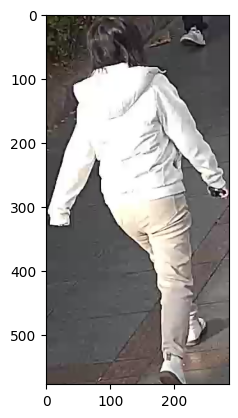

In [10]:
%matplotlib inline
plt.imshow(db_to_crop[1][:, :, ::-1])
plt.show()

# 对search范围内视频分段进行tracking，对每一个框进行编码。设置阈值，若某张图片超过阈值，则将id绑定

In [11]:
timelapse = 1 # +-1min
vid2_date = vid1_date
vid2_time_start = vid1_time_start_minute - timelapse
vid2_time_end = vid1_time_end_minute + timelapse
print(vid2_time_start, vid2_time_end)

vid2s = []

for vid2 in os.listdir(cam2_path):
    if not vid2.endswith('.mp4'):
        continue
    vid2_time = vid2.split('_')[2][:-2]
    vid2_time_hour = int(vid2_time[:2])
    vid2_time_minute = vid2_time_hour*60 + int(vid2_time[2:])
    
    if vid2_time_minute >= vid2_time_start and vid2_time_minute <= vid2_time_end:
        print(vid2)
        vid2s.append(vid2)

555 558
qx351_231208_091558_091659.mp4
qx351_231208_091659_091759.mp4
qx351_231208_091759_091900.mp4


In [12]:
def matching(track_result, vid1_faiss, threshold_distance=200):
    embs = {}
    crops = {}
    maxid = -1
    for idx, fr in enumerate(track_result):
        box_num = fr.boxes.cls.shape[0]
        for i in range(box_num):
            # print(fr.boxes.id)
            if fr.boxes.id is not None:
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                if x1 == 0 or y1 == 0 or x2 == fr.orig_img.shape[1] or y2 == fr.orig_img.shape[0]:
                    continue
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                extract = extractor(crop).cpu().numpy()
                embs[fr.boxes.id[i].item()] = embs[fr.boxes.id[i].item()] + [extract] if fr.boxes.id[i].item() in embs else [extract]
                crops[fr.boxes.id[i].item()] = crops[fr.boxes.id[i].item()] + [crop] if fr.boxes.id[i].item() in crops else [crop]
    for key in embs:
        #random select one image
        idx = np.random.choice(len(embs[key]))
        embs[key] = embs[key][idx]
        crops[key] = crops[key][idx]
    
    all_embs = [embs[key] for key in embs.keys()]
    if len(all_embs) == 0:
        return {}, -1
    maxid = max(embs.keys())
    all_embs = np.vstack([embs[key] for key in embs.keys()])
    
    # search and print distance
    D, I = vid1_faiss.search(all_embs, 1)
    # return D, I
    for idx, key in enumerate(embs.keys()):
        print(f"ID: {key}, Nearest Neighbors: {db_to_trackid[I[idx][0]]}, Distances: {D[idx]}")
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(crops[key][:, :, ::-1])
        ax[0].set_title(f"Query ID: {key}")
        ax[1].imshow(db_to_crop[I[idx][0]][:, :, ::-1])
        ax[1].set_title(f"Matched ID: {db_to_trackid[I[idx][0]]}")
        plt.show()

    # map all embs to their nearest neighbors if distance < threshold
    matched = {}
    for idx, key in enumerate(embs.keys()):
        if D[idx] < threshold_distance:
            matched[key] = db_to_trackid[I[idx][0]]
    return matched, maxid


In [13]:
############################# test #############################
def test_matching(track_result, vid1_faiss, threshold_distance=200):
    embs = {}
    maxid = -1
    for idx, fr in enumerate(track_result):
        box_num = fr.boxes.cls.shape[0]
        for i in range(box_num):
            # print(fr.boxes.id)
            if fr.boxes.id is not None:
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                if x1 == 0 or y1 == 0 or x2 == fr.orig_img.shape[1] or y2 == fr.orig_img.shape[0]:
                    continue
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                extract = extractor(crop).cpu().numpy()
                embs[fr.boxes.id[i].item()] = embs[fr.boxes.id[i].item()] + [extract] if fr.boxes.id[i].item() in embs else [extract]
    for key in embs:
        # random select one image
        idx = np.random.choice(len(embs[key]))
        embs[key] = embs[key][idx]
    
    all_embs = [embs[key] for key in embs.keys()]
    if len(all_embs) == 0:
        return {}, -1
    maxid = max(embs.keys())
    all_embs = np.vstack([embs[key] for key in embs.keys()])
    
    # search and print distance
    D, I = vid1_faiss.search(all_embs, 1)
    # return D, I
    for idx, key in enumerate(embs.keys()):
        print(f"ID: {key}, Nearest Neighbors: {db_to_trackid[I[idx][0]]}, Distances: {D[idx]}")
    # map all embs to their nearest neighbors if distance < threshold
    matched = {}
    for idx, key in enumerate(embs.keys()):
        if D[idx] < threshold_distance:
            matched[key] = db_to_trackid[I[idx][0]]
    return matched, maxid


In [ ]:
# ### ###################### testing

# mappings = {}
# # all_results = []
# maxid = -1
# threshold_distance = 150
# import pickle

# idx = 0
# vid2s_1 = ['/hy-tmp/七贤岭/417334/qx334_231208_100348_100449.mp4']
# for vid2_name in tqdm(vid2s_1):
#     vid2_path = vid2_name
#     print(vid2_path)
#     # track silently
#     track_results = model.track(vid2_path, classes=0, persist=True, verbose=False)
#     # save to file
#     # pickle.dump(track_results, open(f'/hy-tmp/{idx}.pkl', 'wb+'))
#     # all_results.append(track_results.box_results)
#     res, maxid_ = test_matching(track_results, index_vid1, threshold_distance=threshold_distance)
#     maxid = max(maxid, maxid_)
#     if res:
#         mappings = {**mappings, **res}
#     print(res)
#     idx += 1

# print(mappings)

  0%|          | 0/3 [00:00<?, ?it/s]

/hy-tmp/七贤岭/417351/qx351_231208_091558_091659.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[aac @ 0x5617058d4040] TNS filter order 16 is greater than maximum 12.


ID: 30.0, Nearest Neighbors: 13.0, Distances: [     235.68]


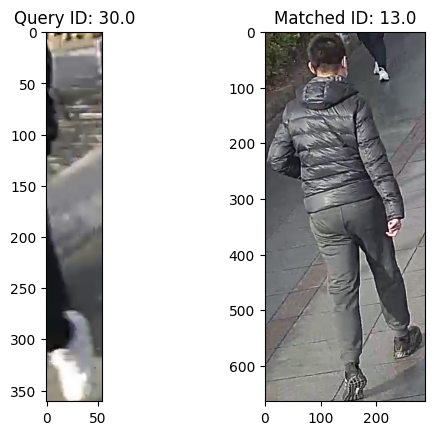

ID: 31.0, Nearest Neighbors: 27.0, Distances: [     192.37]


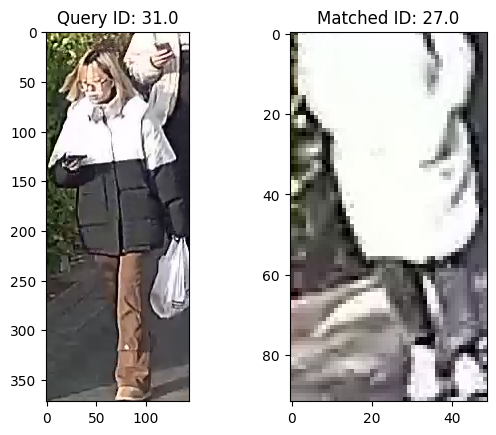

ID: 29.0, Nearest Neighbors: 22.0, Distances: [     209.58]


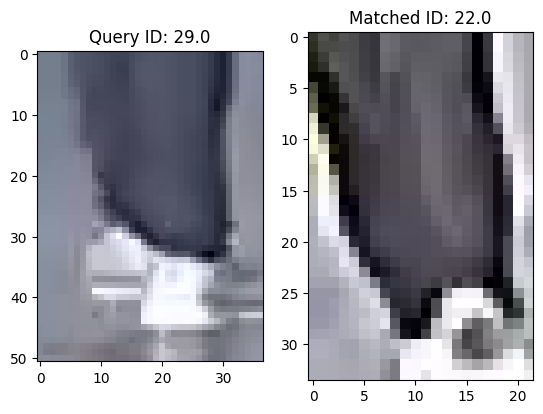

ID: 32.0, Nearest Neighbors: 3.0, Distances: [     116.59]


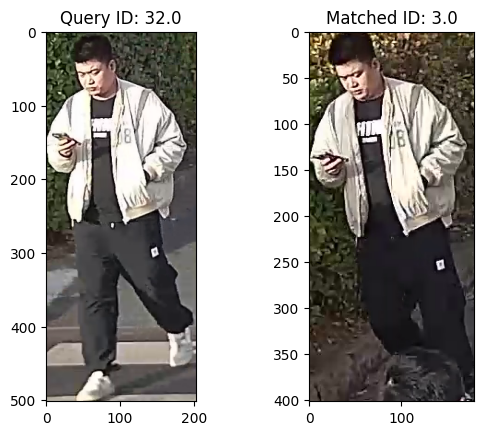

ID: 33.0, Nearest Neighbors: 22.0, Distances: [     183.96]


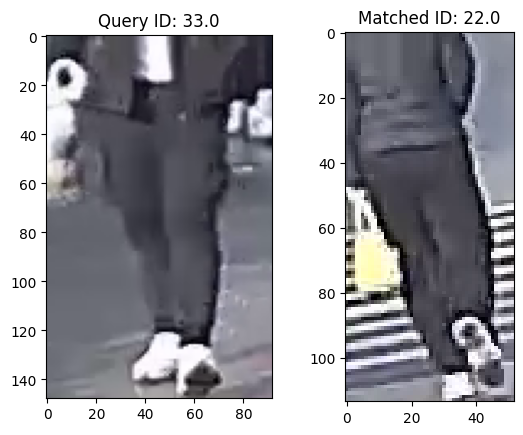

ID: 34.0, Nearest Neighbors: 12.0, Distances: [     172.21]


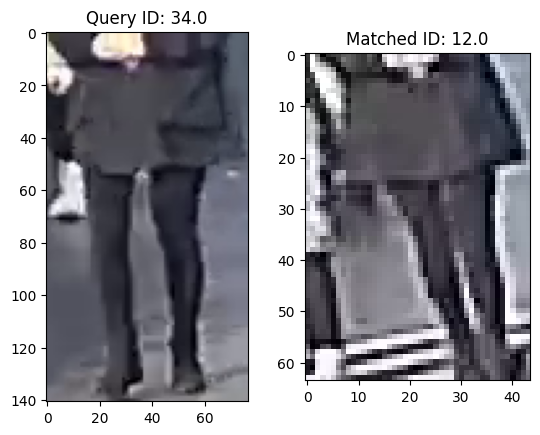

ID: 35.0, Nearest Neighbors: 8.0, Distances: [     131.35]


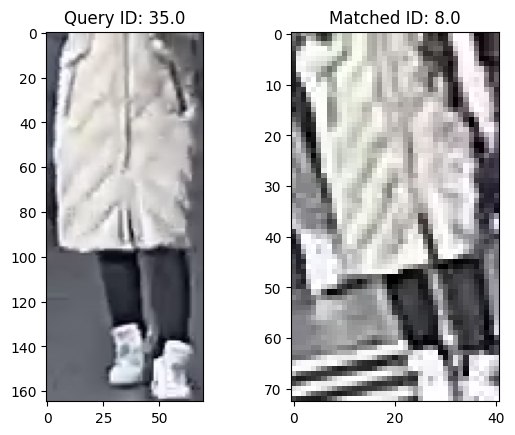

ID: 36.0, Nearest Neighbors: 6.0, Distances: [     411.22]


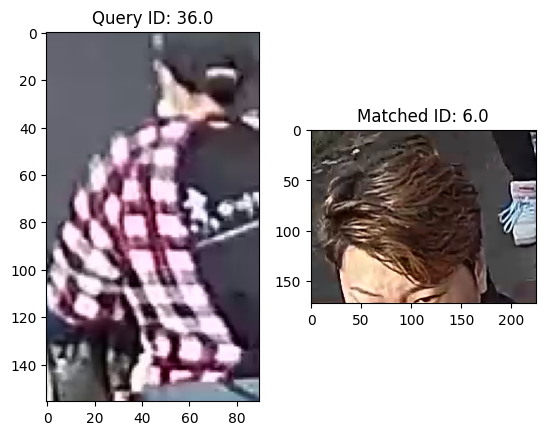

ID: 39.0, Nearest Neighbors: 13.0, Distances: [     227.87]


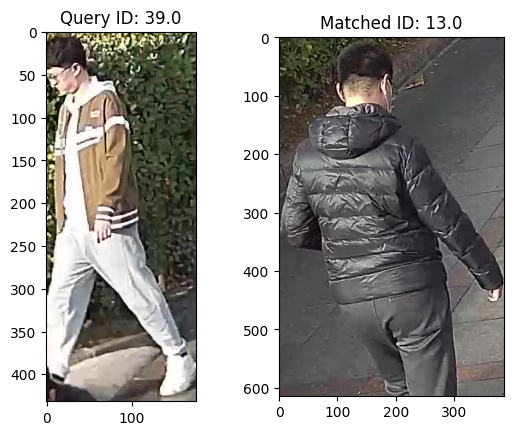

ID: 40.0, Nearest Neighbors: 8.0, Distances: [     188.92]


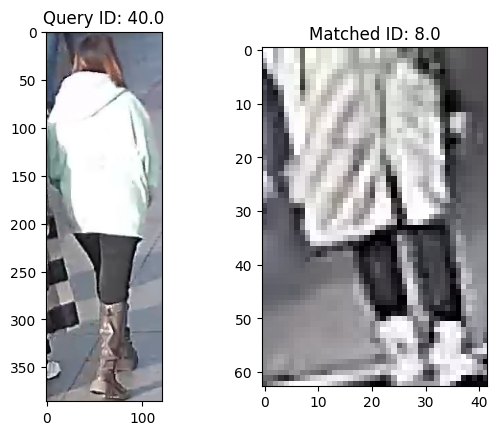

ID: 41.0, Nearest Neighbors: 22.0, Distances: [     244.49]


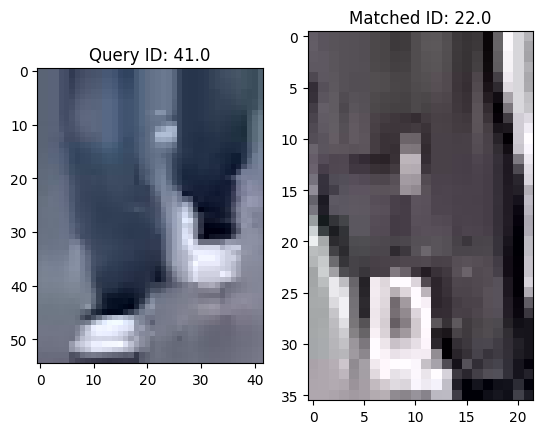

ID: 42.0, Nearest Neighbors: 16.0, Distances: [     251.25]


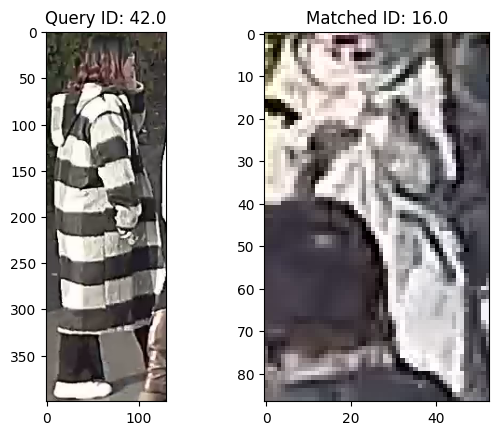

ID: 43.0, Nearest Neighbors: 22.0, Distances: [     206.72]


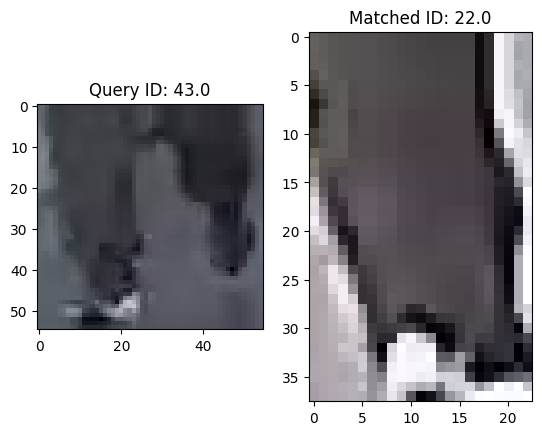

ID: 44.0, Nearest Neighbors: 24.0, Distances: [     148.58]


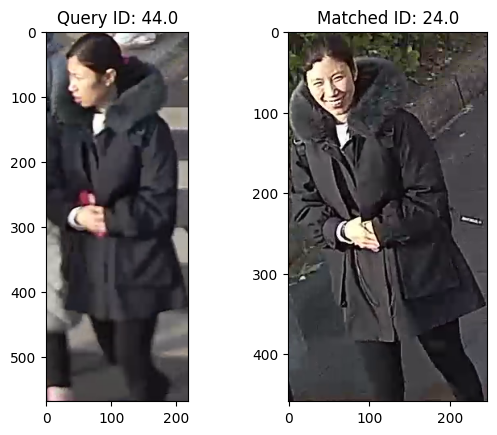

ID: 45.0, Nearest Neighbors: 6.0, Distances: [     77.866]


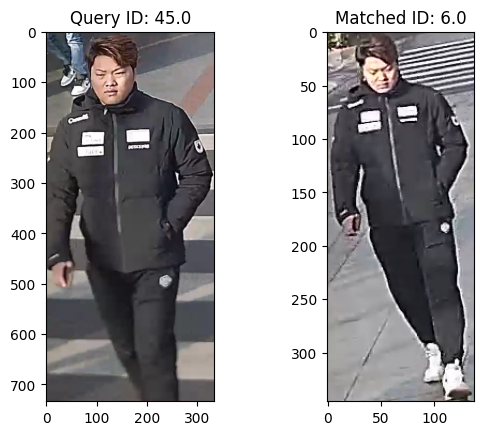

ID: 47.0, Nearest Neighbors: 13.0, Distances: [     227.25]


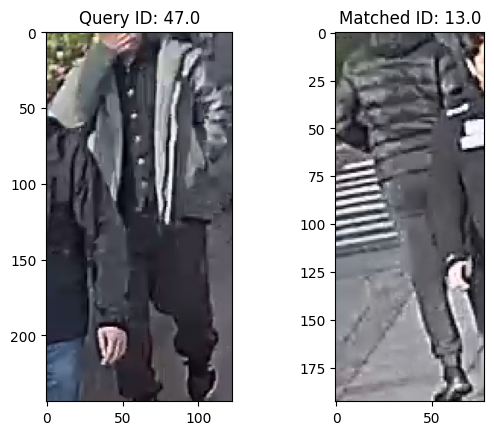

ID: 48.0, Nearest Neighbors: 2.0, Distances: [     67.213]


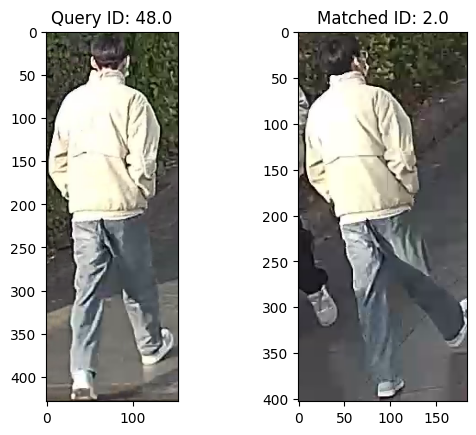

ID: 49.0, Nearest Neighbors: 1.0, Distances: [     45.199]


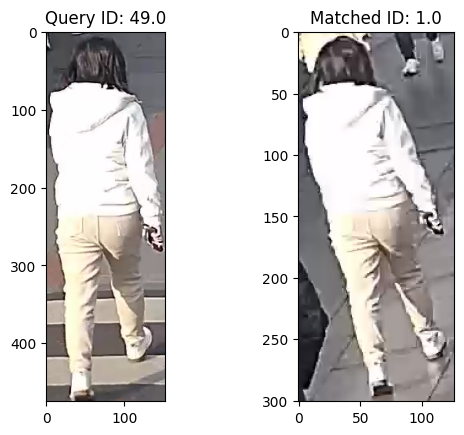

ID: 50.0, Nearest Neighbors: 6.0, Distances: [     162.55]


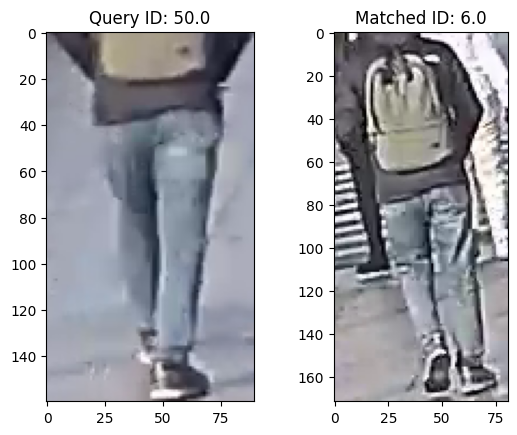

ID: 52.0, Nearest Neighbors: 10.0, Distances: [     152.94]


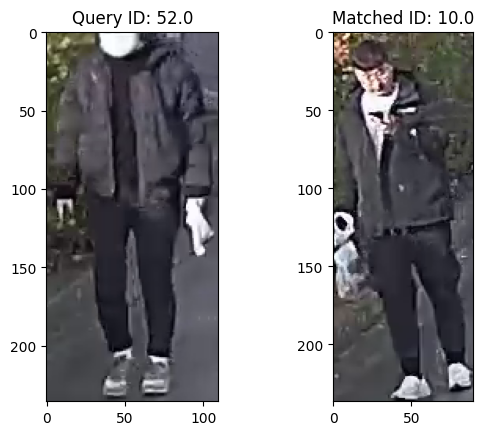

ID: 53.0, Nearest Neighbors: 13.0, Distances: [      69.29]


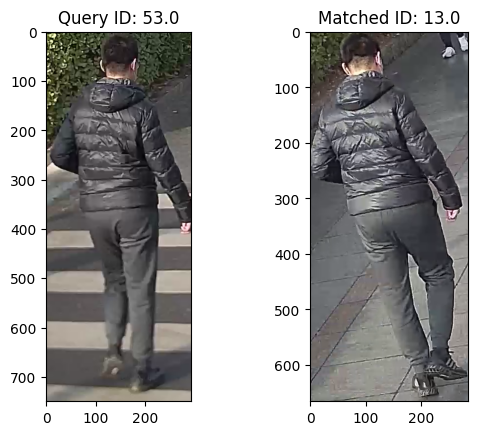

 33%|███▎      | 1/3 [01:06<02:13, 66.66s/it]

{32.0: 3.0, 45.0: 6.0, 48.0: 2.0, 49.0: 1.0, 53.0: 13.0}
/hy-tmp/七贤岭/417351/qx351_231208_091659_091759.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[aac @ 0x561705931c40] TNS filter order 16 is greater than maximum 12.


ID: 50.0, Nearest Neighbors: 4.0, Distances: [     234.03]


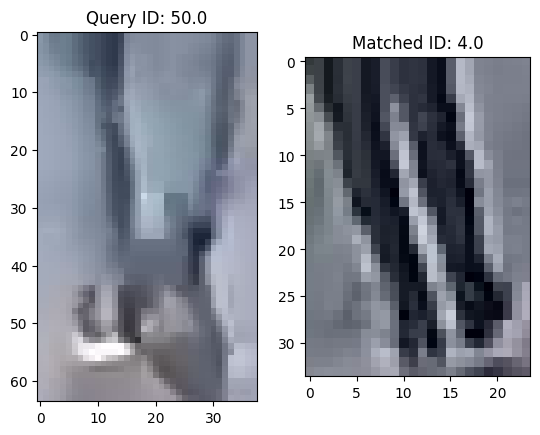

ID: 52.0, Nearest Neighbors: 13.0, Distances: [     154.94]


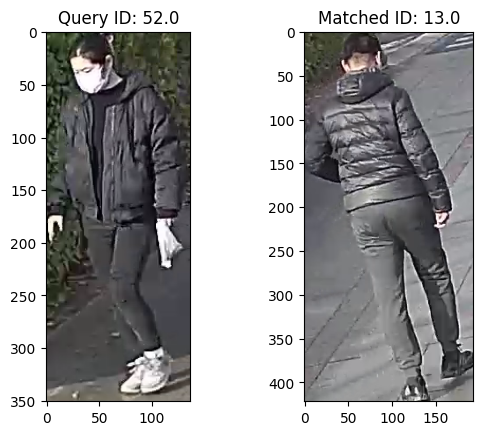

ID: 53.0, Nearest Neighbors: 13.0, Distances: [     150.73]


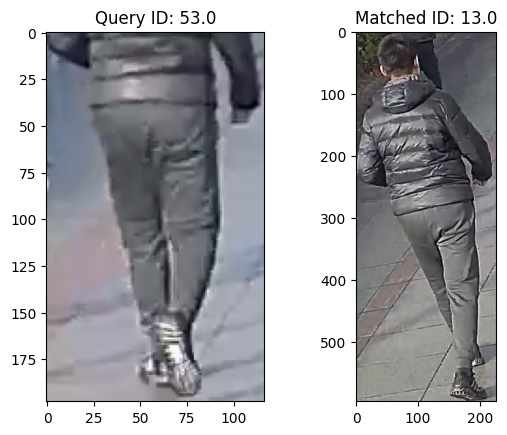

ID: 54.0, Nearest Neighbors: 26.0, Distances: [     66.744]


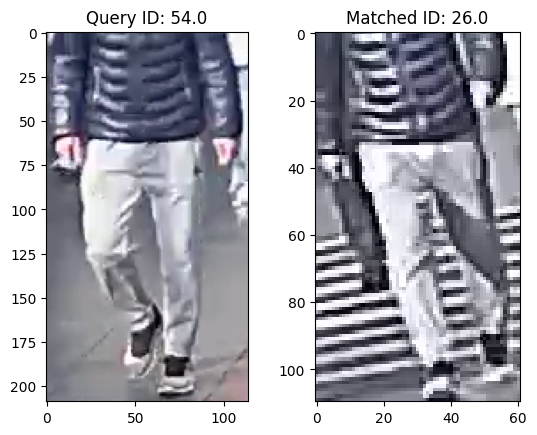

ID: 55.0, Nearest Neighbors: 22.0, Distances: [     53.733]


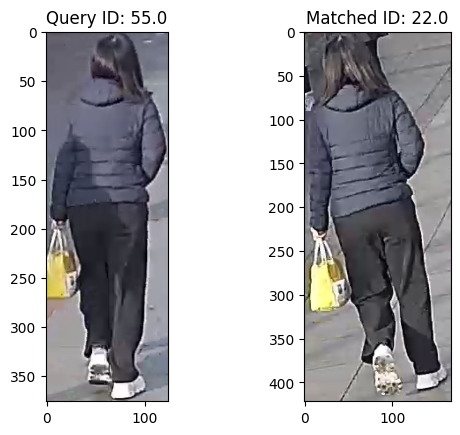

ID: 58.0, Nearest Neighbors: 23.0, Distances: [     124.18]


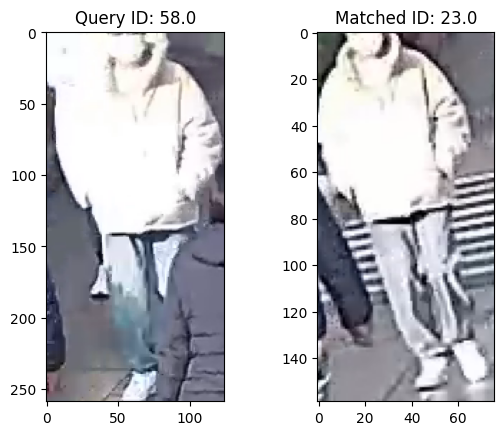

ID: 60.0, Nearest Neighbors: 16.0, Distances: [     218.36]


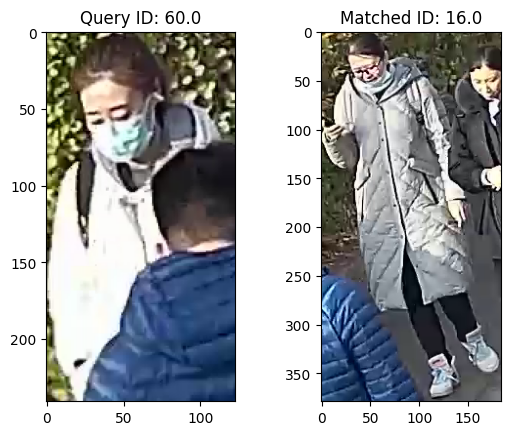

 67%|██████▋   | 2/3 [01:39<00:46, 46.79s/it]

{54.0: 26.0, 55.0: 22.0, 58.0: 23.0}
/hy-tmp/七贤岭/417351/qx351_231208_091759_091900.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[aac @ 0x561705a87c40] TNS filter order 14 is greater than maximum 12.


ID: 61.0, Nearest Neighbors: 20.0, Distances: [     218.09]


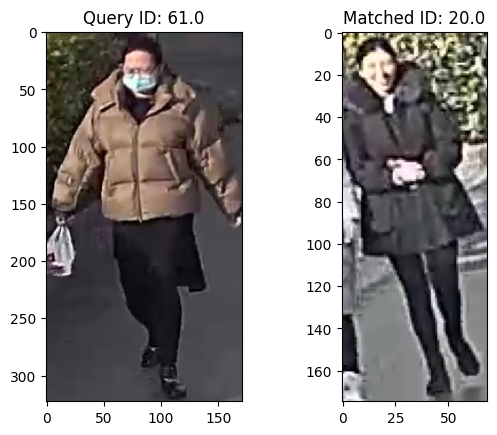

ID: 62.0, Nearest Neighbors: 4.0, Distances: [     414.85]


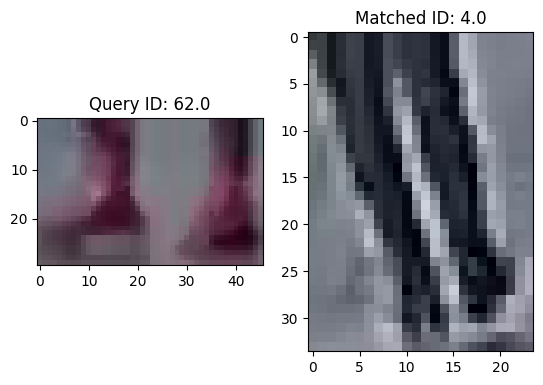

ID: 63.0, Nearest Neighbors: 8.0, Distances: [     213.54]


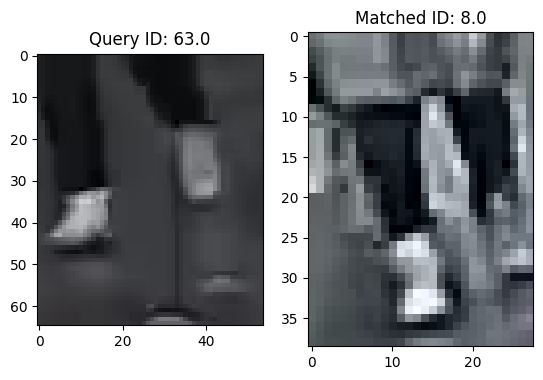

ID: 64.0, Nearest Neighbors: 6.0, Distances: [     187.89]


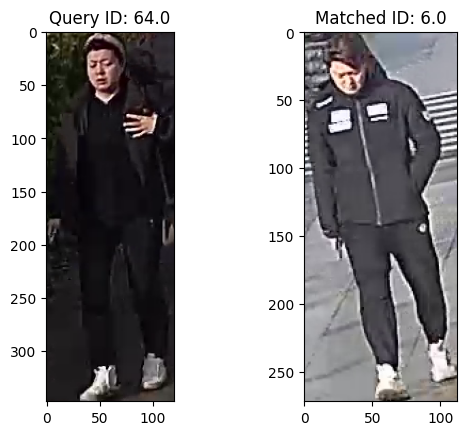

ID: 65.0, Nearest Neighbors: 20.0, Distances: [     219.88]


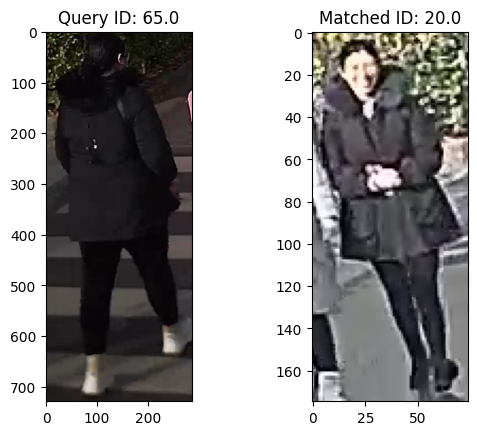

ID: 67.0, Nearest Neighbors: 9.0, Distances: [     172.23]


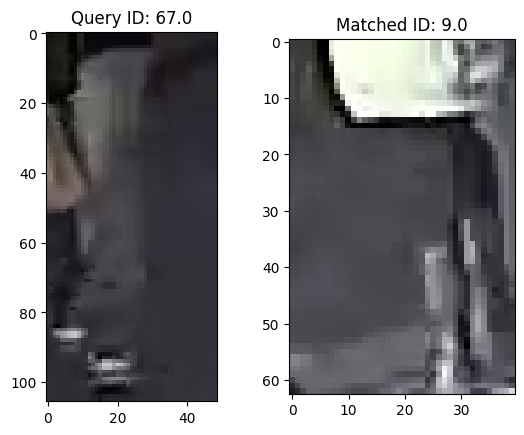

ID: 68.0, Nearest Neighbors: 13.0, Distances: [     167.24]


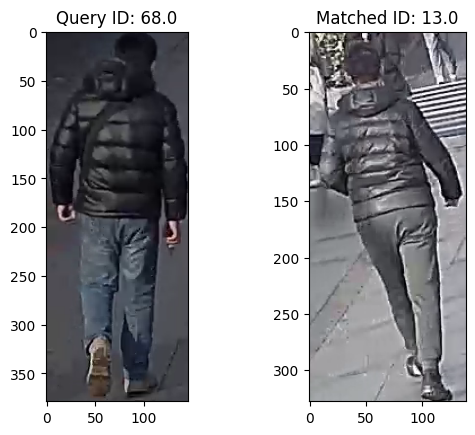

ID: 69.0, Nearest Neighbors: 3.0, Distances: [     219.07]


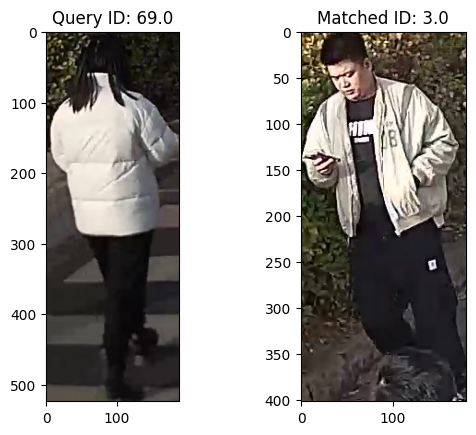

ID: 70.0, Nearest Neighbors: 24.0, Distances: [     180.83]


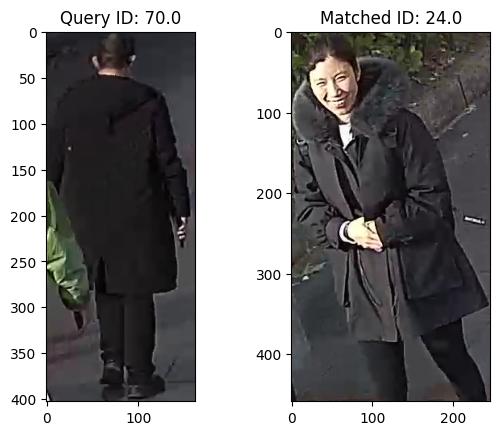

ID: 71.0, Nearest Neighbors: 1.0, Distances: [     190.22]


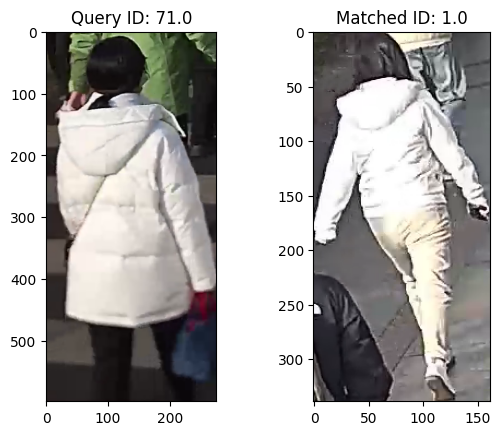

ID: 72.0, Nearest Neighbors: 16.0, Distances: [     265.25]


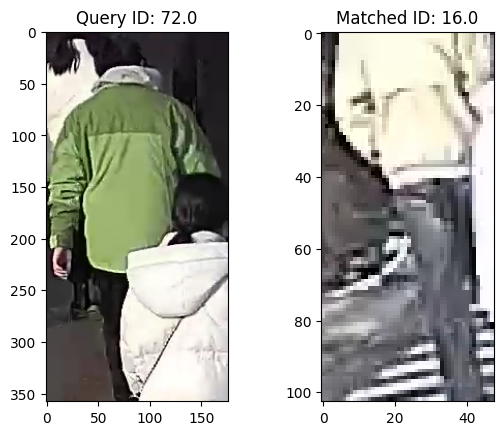

ID: 73.0, Nearest Neighbors: 26.0, Distances: [     202.53]


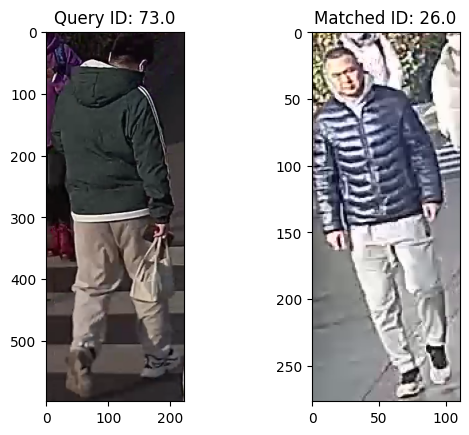

ID: 75.0, Nearest Neighbors: 2.0, Distances: [     218.33]


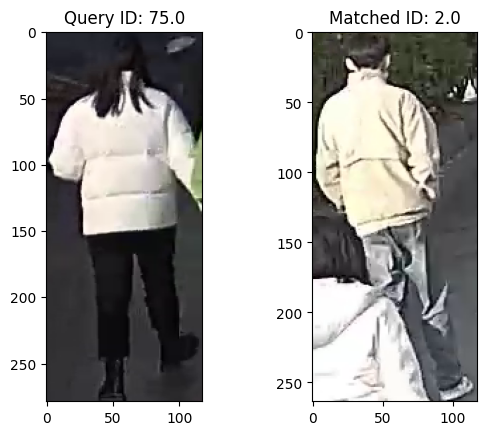

ID: 76.0, Nearest Neighbors: 4.0, Distances: [      282.4]


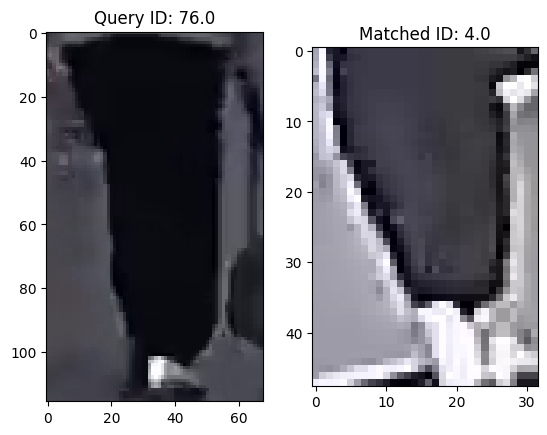

ID: 77.0, Nearest Neighbors: 4.0, Distances: [     182.67]


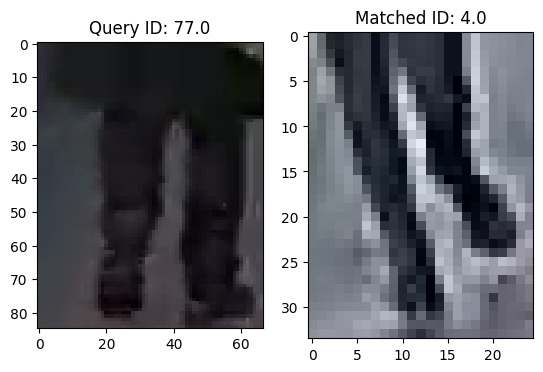

ID: 78.0, Nearest Neighbors: 26.0, Distances: [     183.05]


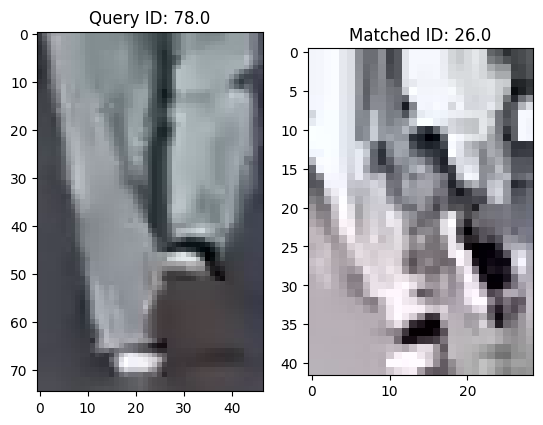

ID: 79.0, Nearest Neighbors: 22.0, Distances: [     161.19]


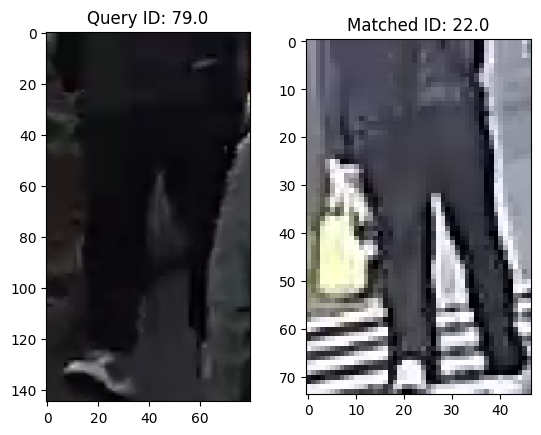

ID: 81.0, Nearest Neighbors: 4.0, Distances: [     235.62]


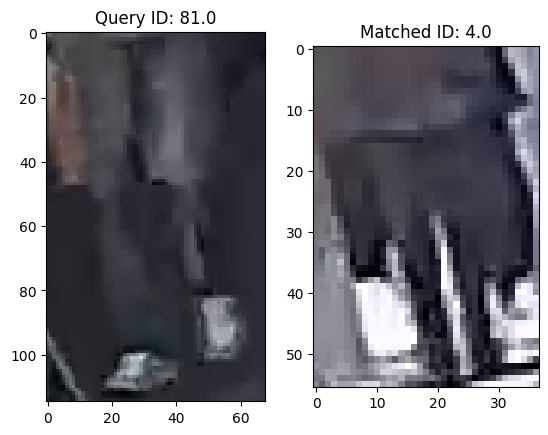

ID: 82.0, Nearest Neighbors: 4.0, Distances: [        231]


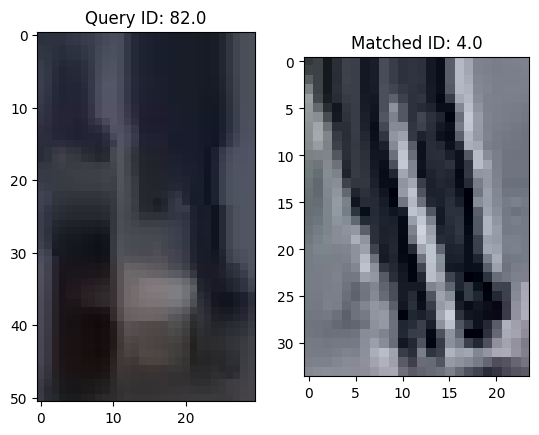

ID: 84.0, Nearest Neighbors: 2.0, Distances: [     176.05]


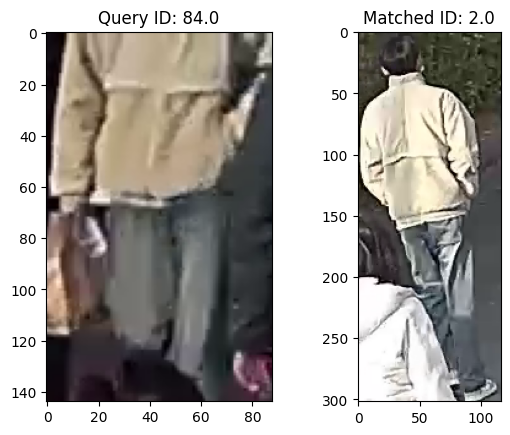

ID: 87.0, Nearest Neighbors: 22.0, Distances: [      165.1]


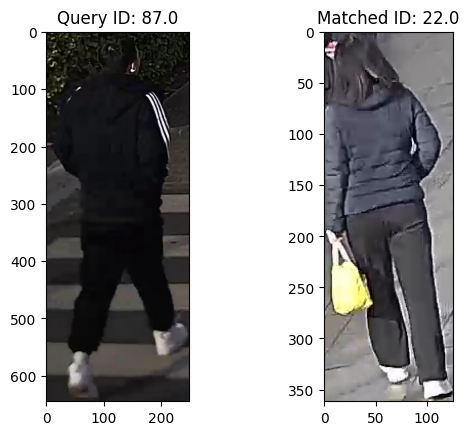

ID: 89.0, Nearest Neighbors: 22.0, Distances: [     226.36]


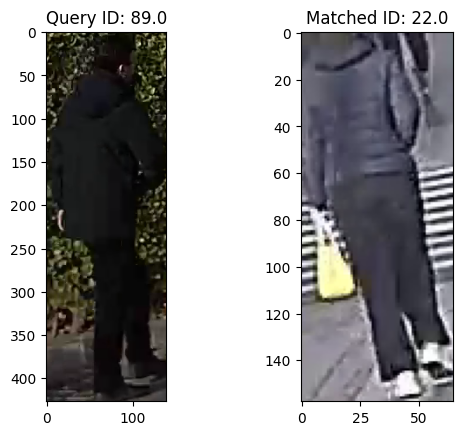

ID: 88.0, Nearest Neighbors: 22.0, Distances: [     187.04]


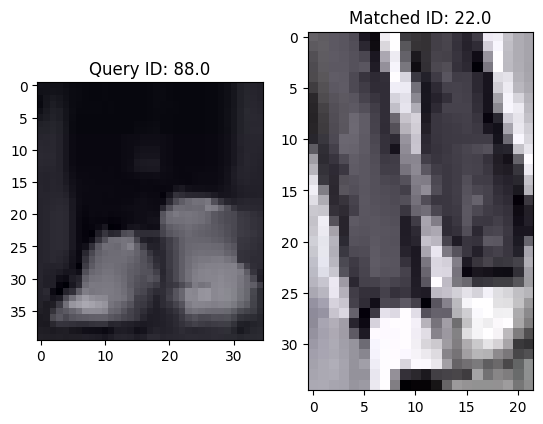

100%|██████████| 3/3 [02:41<00:00, 53.83s/it]

{}
{32.0: 3.0, 45.0: 6.0, 48.0: 2.0, 49.0: 1.0, 53.0: 13.0, 54.0: 26.0, 55.0: 22.0, 58.0: 23.0}


In [13]:
mappings = {}
# all_results = []
maxid = -1
threshold_distance = 125
import pickle

idx = 0
for vid2_name in tqdm(vid2s):
    vid2_path = os.path.join(cam2_path, vid2_name)
    print(vid2_path)
    # track silently
    track_results = model.track(vid2_path, classes=0, persist=True, verbose=False)
    # save to file
    pickle.dump(track_results, open(f'/hy-tmp/{idx}.pkl', 'wb+'))
    # all_results.append(track_results.box_results)
    res, maxid_ = matching(track_results, index_vid1, threshold_distance=threshold_distance)
    maxid = max(maxid, maxid_)
    if res:
        mappings = {**mappings, **res}
    print(res)
    idx += 1
            # img = fr.orig_img.copy()
            # for i in range(box_num):
            #     if fr.boxes.id is not None:
            #         x1, y1, x2, y2 = fr.boxes.xyxy[i]
            #         crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
            #         extract = extractor(crop)
            #         index.add(extract.cpu().numpy())
            #         time = vid1_datetime_start + pd.Timedelta(seconds=idx/fps)
            #         infos.append({'img': crop, 'size':(x2-x1)*(y2-y1), 'time':time, 'id': fr.boxes.id[i].item()})
print(mappings)

In [14]:
# for vid2_name in tqdm(vid2s):
#     vid2_path = os.path.join(cam2_path, vid2_name)
#     os.system('cp ' + vid2_path + ' ./vid/')

In [15]:
maxid

89.0

In [16]:
max_ids = int(maxid)
# create random colors of max_ids
color_table = {i: tuple(np.random.randint(0, 255, 3)) for i in range(1, max_ids + 1)}
color_table

{1: (13, 28, 197),
 2: (116, 202, 0),
 3: (99, 189, 254),
 4: (169, 85, 37),
 5: (139, 152, 31),
 6: (226, 36, 137),
 7: (95, 128, 197),
 8: (152, 68, 221),
 9: (122, 163, 191),
 10: (172, 92, 194),
 11: (8, 112, 6),
 12: (28, 157, 226),
 13: (184, 235, 111),
 14: (235, 200, 117),
 15: (122, 137, 80),
 16: (128, 47, 141),
 17: (133, 198, 137),
 18: (144, 130, 241),
 19: (190, 133, 19),
 20: (158, 71, 196),
 21: (41, 7, 201),
 22: (197, 43, 22),
 23: (8, 34, 31),
 24: (27, 8, 100),
 25: (248, 127, 241),
 26: (95, 157, 225),
 27: (238, 18, 154),
 28: (208, 179, 185),
 29: (81, 138, 57),
 30: (166, 152, 19),
 31: (211, 133, 151),
 32: (147, 203, 183),
 33: (61, 195, 188),
 34: (27, 24, 126),
 35: (155, 216, 168),
 36: (117, 242, 114),
 37: (153, 191, 222),
 38: (37, 231, 156),
 39: (181, 35, 10),
 40: (108, 39, 229),
 41: (83, 36, 12),
 42: (180, 230, 249),
 43: (17, 139, 216),
 44: (77, 152, 23),
 45: (99, 20, 164),
 46: (38, 51, 242),
 47: (116, 194, 144),
 48: (127, 35, 141),
 49: (232

In [18]:
# 输出视频

# vid1_imgs = []
width = 1920
height = 1080
# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'multi_query_1.mp4')
print(output_name)

# use pyAV for video writing

output_video = av.open(output_name, mode='w')
stream = output_video.add_stream('mpeg4', rate=fps)
stream.width = width
stream.height = height
# stream.pix_fmt = 'yuv420p'

result_pickle = pickle.load(open(f'/hy-tmp/1.pkl', 'rb'))

for fr in result_pickle:
    box_num = fr.boxes.cls.shape[0]
    img = fr.orig_img.copy()
    if box_num > 0:
        # break
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            if fr.boxes.id is not None:
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                # draw rectangle
                if fr.boxes.id[i].item() in mappings:
                    color = color_table[mappings[fr.boxes.id[i].item()]]
                    text = f"ID matched: {mappings[fr.boxes.id[i].item()]} !"
                    text_color = (0, 0, 255)
                else:
                    color = color_table[fr.boxes.id[i].item()]
                    text = f"ID: {fr.boxes.id[i].item()}"
                    text_color = (255, 0, 0)
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (int(color[0]), int(color[1]), int(color[2])), 10)
                # add id
                # auto adjust text position, if the text is out of the image, move it to another side of the box which has more space
                if y1 < 50:
                    y1 = y2
                if x1 < 50:
                    x1 = x2

                img = cv2.putText(img, text, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2, cv2.LINE_AA)  
    # write to video
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frame = av.VideoFrame.from_ndarray(img, format='rgb24')
    for packet in stream.encode(frame):
        output_video.mux(packet)
output_video.close()

./temp/multi_query_1.mp4


In [19]:
# 输出原始视频做对比

# vid1_imgs = []
width = 1920
height = 1080
# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'multi_gallery.mp4')
print(output_name)

output_video = av.open(output_name, mode='w')
stream = output_video.add_stream('mpeg4', rate=fps)
stream.width = width
stream.height = height


for fr in track_results_vid1:
    box_num = fr.boxes.cls.shape[0]
    img = fr.orig_img.copy()
    if box_num > 0:
        # break
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            if fr.boxes.id is not None:
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                # draw rectangle
                color = color_table[fr.boxes.id[i].item()]
                text = f"ID: {fr.boxes.id[i].item()}"
                text_color = (255, 0, 0)
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (int(color[0]), int(color[1]), int(color[2])), 10)
                # add id
                # auto adjust text position, if the text is out of the image, move it to another side of the box which has more space
                if y1 < 50:
                    y1 = y2
                if x1 < 50:
                    x1 = x2

                img = cv2.putText(img, text, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2, cv2.LINE_AA)  
    # write to video
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frame = av.VideoFrame.from_ndarray(img, format='rgb24')
    for packet in stream.encode(frame):
        output_video.mux(packet)

output_video.close()

./temp/multi_gallery.mp4


In [ ]:
%matplotlib inline
for fr in track_results_vid1:
    box_num = fr.boxes.cls.shape[0]
    img = fr.orig_img.copy()
    if box_num > 0:
        # break
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            if fr.boxes.id is not None and int(fr.boxes.id[i].item()) == 23:
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                plt.imshow(crop)
                plt.show()


In [4]:
# play temp/multi_query_0.mp4 first, and then play temp/multi_query_1.mp4
cmd = f"ffmpeg -i temp/multi_query_0.mp4 -i temp/multi_query_1.mp4 -filter_complex hstack temp/output.mp4 -y"

In [ ]:
import os
os.system(cmd)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [89]:
# # use ffmpeg to concat all videos into a single video
# with open('temp/vid2.txt', 'w') as f:
#     for vid2 in vid2s:
#         f.write(f"file '{os.path.join(cam2_path, vid2)}'\n")
# cmd = f"ffmpeg -f concat -safe 0 -i temp/vid2.txt -c copy {output_name} -y"

In [ ]:
# os.system(cmd)

In [ ]:
# # 对范围进行track
# track_model_vid2 = YOLO('/root/yolov8x.pt')
# track_results_vid2 = track_model_vid2.track(output_name, classes=0, persist=True)

In [ ]:
# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm import tqdm

#loading a YOLO model from disk
model = YOLO('/root/yolov8x.pt')


#geting names from classes
dict_classes = model.model.names

### Configurations
# Scaling percentage of original frame
scale_percent = 100
#-------------------------------------------------------
# Reading video with cv2
output_name = '/root/YOLO-ViT-PGC/temp/merged.mp4'
video = cv2.VideoCapture(output_name)

# Objects to detect Yolo
class_IDS = [0] 
# Auxiliary variables
centers_old = {}


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance 
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

In [ ]:
from torchreid.reid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/root/osnet_x1_0_imagenet.pth',
    device='cuda'
)

In [ ]:
# vector search
import faiss
index = faiss.IndexFlatL2(512)

%matplotlib inline
# get frame per 2 seconds
frame_interval = int(fps * 2)
infos = []
# tqdm
from tqdm.notebook import trange
for idx in trange(0, int(video.get(cv2.CAP_PROP_FRAME_COUNT)), frame_interval):
    video.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = video.read()
    # bgr to rgb
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if not ret:
        break
    # detect objects in the frame, conf>0.5
    results = model(frame, classes=class_IDS, conf=0.8)
    for r in results:
        # print(r)
        # print(r.boxes.xywh)
        box_num = r.boxes.cls.shape[0]
        if box_num:
            for i in range(box_num):
                _, _, w, h = r.boxes.xywh[i]
                if w <= h: 
                    # has detections and is a vertical rectangle
                    # crop
                    x1, y1, x2, y2 = r.boxes.xyxy[i]
                    crop = frame[int(y1):int(y2), int(x1):int(x2)]
                    # show the crop
                    # plt.imshow(crop)
                    # plt.show()
                    extract = extractor(crop)
                    # print(extract.shape)
                    # print(extract)
                    index.add(extract.cpu().numpy())
                    infos.append({
                        'img': crop,
                        'time': start_time + datetime.timedelta(seconds=idx // fps),
                        'frame': idx,
                        'pos': (x1, y1, x2, y2)
                    })
            if box_num >= 5:
                print(start_time + datetime.timedelta(seconds=idx // fps))
                plt.imshow(frame)
                plt.show()
                    # show the frame
                    # plt.imshow(r.plot())
                    # plt.show()
    

In [ ]:
index.ntotal

In [ ]:
print(len(infos))
infos[:5]

# 以上是进行数据库建立，接下来在视频中并在数据库查找最相近的人

In [ ]:
model = YOLO('/root/yolov8x.pt')
track_results = model.track(path, classes=0, persist=True)

In [ ]:
people_set = set([1., 2.])
color_dict = {1.: (0, 255, 0), 2.: (0, 0, 255)}
flag = 1
# vid1_imgs = []

# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'vid1.mp4')
print(output_name)

VIDEO_CODEC = "mp4v"

output_video = cv2.VideoWriter(output_name, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))

for fr in track_results[:]:
    box_num = fr.boxes.cls.shape[0]
    if box_num > 0:
        # break
        img = fr.orig_img.copy()
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            if w <= h and (fr.boxes.id is not None) and fr.boxes.id[i].item() in people_set: 
                # print(fr.boxes.id[i].item())
                # has detections and is a vertical rectangle
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                # print(fr.boxes)
                
                # bgr to rgb
                # img = cv2.cvtColor(fr.orig_img, cv2.COLOR_BGR2RGB)

                # output_video.write(fr.plot())

                # add ori_img with box
                
                if flag:
                    flag -= 1
                    plt.imshow(img)
                    plt.show()
                    extract = extractor(crop)
                    # find in index
                    D, I = index.search(extract.cpu().numpy(), 1)
                    # print(D, I)
                    # show infos
                    for j in I[0]:
                        print(infos[j]['time'])
                        search_time = infos[j]['time']
                        search_I = I
                        plt.imshow(infos[j]['img'])
                        plt.show()
                # print(fr.boxes.id[i].item())
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color_dict[fr.boxes.id[i].item()], 10)
        
        flag_ = False
        if fr.boxes.id is not None:
            for id_ in fr.boxes.id:
                if id_.item() in people_set:
                    flag_ = True
                    break
        if flag_:
            output_video.write(img)        

output_video.release()

In [ ]:
search_time

In [ ]:
for vid in vid2s:
    vid_name = os.path.join(cam2_path, vid)
    vid_date = vid_name.split('_')[1]
    vid_time_start = vid_name.split('_')[2]
    vid_time_start_hour = int(vid_time_start[:2])
 

    vid_time_end = vid_name.split('_')[3][:-4]
    vid_time_end_hour = int(vid_time_end[:2])


    vid_start_datetime = datetime.datetime(int('20' + vid_date[:2]), int(vid_date[2:-2]), int(vid_date[-2:]), vid_time_start_hour, int(vid_time_start[2:4]), int(vid_time_start[4:]))
    vid_end_datetime = datetime.datetime(int('20' + vid_date[:2]), int(vid_date[2:-2]), int(vid_date[-2:]), vid_time_end_hour, int(vid_time_end[2:4]), int(vid_time_end[4:]))

    if search_time >= vid_start_datetime and search_time <= vid_end_datetime:
        print(vid_name)
        vid2_search_start_datetime = vid_start_datetime
        vid2_fine = vid_name
        break

In [ ]:
model = YOLO('/root/yolov8x.pt')
vid2_track_results = model.track(vid2_fine, classes=0, persist=True)

In [ ]:
vid2_search_start_datetime

In [ ]:
flag = False

delta = search_time - vid2_search_start_datetime

# to frame
delta_frame = int(delta.total_seconds() * fps)
print(delta_frame)

# print(infos[search_I[0][0]]['pos'])
max_iou = -1
x1_, y1_, x2_, y2_ = infos[search_I[0][0]]['pos']
for i, (x1, y1, x2, y2) in enumerate(vid2_track_results[delta_frame].boxes.xyxy):
    iou = (min(x2, x2_) - max(x1, x1_)) * (min(y2, y2_) - max(y1, y1_)) / ((x2 - x1) * (y2 - y1) + (x2_ - x1_) * (y2_ - y1_) - (min(x2, x2_) - max(x1, x1_)) * (min(y2, y2_) - max(y1, y1_)))
    if iou > max_iou:
        max_iou = iou
        most_pos_id = vid2_track_results[delta_frame].boxes.id[i]
    plt.imshow(vid2_track_results[delta_frame].plot())
    plt.show()
    # add rectangle to the image, but not change the original image
    img = vid2_track_results[delta_frame].orig_img.copy()
    img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 10)
    plt.imshow(img)
    plt.show()
    print(iou)
    print(infos[search_I[0][0]]['pos'])
    print(x1, y1, x2, y2)
    print(most_pos_id)

In [ ]:
plt.imshow(vid2_track_results[delta_frame].orig_img)

In [ ]:
people_set = set()
flag = 1
color_dict = {4.: (0, 255, 0), 5.: (0, 0, 255)}
# vid1_imgs = []

# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'vid2.mp4')
print(output_name)

VIDEO_CODEC = "mp4v"

output_video = cv2.VideoWriter(output_name, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))

for fr in vid2_track_results[:]:
    box_num = fr.boxes.cls.shape[0]
    if box_num:
        # break
        flag_ = False
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            img = fr.orig_img.copy()
            
            if (fr.boxes.id is not None) and fr.boxes.id[i].item() in [4., 5.]:
                flag_ = True
                # print(fr.boxes.id[i].item())
                # has detections and is a vertical rectangle
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                # print(fr.boxes)
                
                # bgr to rgb
                # img = cv2.cvtColor(fr.orig_img, cv2.COLOR_BGR2RGB)

                # output_video.write(fr.plot())

                # add ori_img with box
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color_dict[fr.boxes.id[i].item()], 10)
                
                if flag:
                    flag -= 1
                    plt.imshow(img)
                    plt.show()
        if flag_:
            output_video.write(img)
output_video.release()

In [ ]:
# merge two videos, left is vid1, right is vid2
vid1 = cv2.VideoCapture('./temp/' + 'vid1.mp4')
vid2 = cv2.VideoCapture('./temp/' + 'vid2.mp4')

output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'final.mp4')
print(output_name)

# use ffmpeg to concat all videos into a single video
cmd = f"ffmpeg -i ./temp/vid1.mp4 -i ./temp/vid2.mp4 -filter_complex hstack {output_name} -y"


In [ ]:
os.system(cmd)